This script is used to review data contents

In [1]:
import pandas as pd

df_all = pd.read_csv('paper-figure_celllist_all.csv')
print(f'Number of samples: {df_all.shape[0]}')

Number of samples: 1124


In [2]:
print('Number of samples by class and site:\n---------------------------------------------')
cytology_class = pd.api.types.CategoricalDtype(['NILM','ASC-US','LSIL','ASC-H','HSIL', 'SCC'], ordered=True)
print(pd.crosstab(df_all['Facility'], df_all['Class'].astype(cytology_class)))
print('\n')
print('Number of samples by hpv test result and site:\n------------------------------------------')
hpv_class = pd.api.types.CategoricalDtype(['-', '+'], ordered=True)
print(pd.crosstab(df_all['Facility'], df_all['HPV'].astype(hpv_class)))

Number of samples by class and site:
---------------------------------------------
Class      NILM  ASC-US  LSIL  ASC-H  HSIL  SCC
Facility                                       
1_CIH       169      72    42      9    24    2
2_Tsukuba    55      31    54     17    54   11
3_Kaetsu     85     211    69      1    18    1
4_Junten     49      25    50      0    50   25


Number of samples by hpv test result and site:
------------------------------------------
HPV          -    +
Facility           
1_CIH      139  127
2_Tsukuba   28  107
3_Kaetsu   162  223
4_Junten    12   16


In [3]:
cols = list(cytology_class.categories) + ['Total']

rows = []
for facility in df_all['Facility'].unique():

    # Total counts
    counts = (df_all.loc[df_all['Facility'] == facility, 'Class']
                    .value_counts()
                    .reindex(cytology_class.categories, fill_value=0))
    rows.append(
        {'Facility': facility, 'HPV': ''} |
        counts.to_dict() |
        {'Total': int(counts.sum())}
    )

    # HPV specific (-, +, NA)
    for hpv in ['-', '+', pd.NA]:
        if hpv is pd.NA:
            mask = (df_all['Facility'] == facility) & (df_all['HPV'].isna())
            hpv_label = 'N/A'
        else:
            mask = (df_all['Facility'] == facility) & (df_all['HPV'] == hpv)
            hpv_label = hpv

        counts_hpv = (df_all.loc[mask, 'Class']
                          .value_counts()
                          .reindex(cytology_class.categories, fill_value=0))

        rows.append(
            {'Facility': f'  {facility}', 'HPV': f'{hpv_label}'} |
            counts_hpv.to_dict() |
            {'Total': int(counts_hpv.sum())}
        )


table = pd.DataFrame(rows)[['Facility','HPV'] + cols].fillna(0).astype({c:'int64' for c in cols})
styled = (table.style
          .set_properties(subset=['Facility'], **{'text-align':'left'})
          .set_properties(subset=['HPV'], **{'text-align':'center'})
          .set_properties(subset=cols, **{'text-align':'right'}))
styled 


,Facility,HPV,NILM,ASC-US,LSIL,ASC-H,HSIL,SCC,Total
0,1_CIH,,169,72,42,9,24,2,318
1,1_CIH,-,84,45,5,3,2,0,139
2,1_CIH,+,57,26,30,3,9,2,127
3,1_CIH,N/A,28,1,7,3,13,0,52
4,2_Tsukuba,,55,31,54,17,54,11,222
5,2_Tsukuba,-,6,9,8,2,3,0,28
6,2_Tsukuba,+,10,13,36,9,39,0,107
7,2_Tsukuba,N/A,39,9,10,6,12,11,87
8,3_Kaetsu,,85,211,69,1,18,1,385
9,3_Kaetsu,-,41,113,8,0,0,0,162


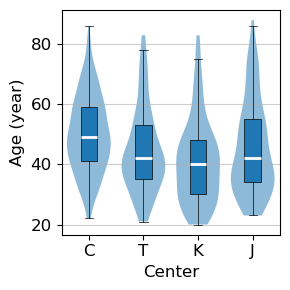

C: Median=49.0, Q1=41.0, Q3=59.0
T: Median=42.0, Q1=35.0, Q3=53.0
K: Median=40.0, Q1=30.0, Q3=48.0
J: Median=42.0, Q1=34.0, Q3=55.0


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fig_dir = 'figs/'
os.makedirs(fig_dir, exist_ok=True)

facility_labels = {
    '1_CIH': 'C', 
    '2_Tsukuba': 'T', 
    '3_Kaetsu': 'K', 
    '4_Junten': 'J', 
    '5_Mita': 'M' 
}

d = df_all[['Facility', 'Age']].copy()
d['Age'] = pd.to_numeric(d['Age'])

order_keys = list(facility_labels.keys())
facilities_present = [k for k in order_keys if (d['Facility'] == k).any()]

data = [d.loc[d['Facility'] == k, 'Age'].values for k in facilities_present]
labels = [facility_labels[k] for k in facilities_present]

# Violin plot
fig, ax = plt.subplots(figsize=(3,3))
v = ax.violinplot(
    data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.8
)
for b in v['bodies']:
    b.set_alpha(0.5)

# Box plot
positions = np.arange(1, len(facilities_present) + 1)
bparts = ax.boxplot(
    data,
    positions=positions,
    widths=0.3,
    showfliers=False,
    patch_artist=True,
    medianprops=dict(linewidth=2, color='white'),
    whiskerprops=dict(linewidth=0.5),
    capprops=dict(linewidth=0.5),
    boxprops=dict(linewidth=0.5)
)

# Axis settings
ax.set_xticks(positions, labels)
ax.set_xlabel("Center", fontsize=12)
ax.set_ylabel("Age (year)", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.grid(True, linestyle="-", alpha=0.6)

fig.tight_layout()

plt.show()
fig.savefig(f'{fig_dir}/Efig11b_age-distribution-by-facility.svg', bbox_inches='tight')

# Median values
medians = [np.median(ages) for ages in data]
q1 = [np.percentile(ages, 25) for ages in data]
q3 = [np.percentile(ages, 75) for ages in data]
for i, facility in enumerate(facilities_present):
    print(f'{facility_labels[facility]}: Median={medians[i]}, Q1={q1[i]}, Q3={q3[i]}')

In [5]:
print(pd.crosstab(df_all['Facility'], df_all['SlideType']))

SlideType   BD  Thinprep
Facility                
1_CIH      265        53
2_Tsukuba  222         0
3_Kaetsu   385         0
4_Junten   199         0


In [6]:
df_C = df_all[df_all['Facility'] == '1_CIH']

pd.crosstab(df_C['SlideType'], df_C['Class'].astype(cytology_class))

Class,NILM,ASC-US,LSIL,ASC-H,HSIL,SCC
SlideType,,,,,,
BD,141,71,35,6,11,1
Thinprep,28,1,7,3,13,1


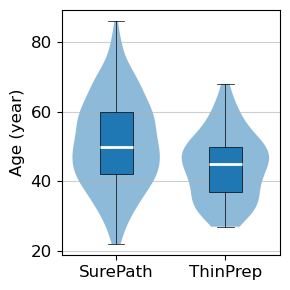

SurePath: Median=50.0, Q1=42.0, Q3=60.0
ThinPrep: Median=45.0, Q1=37.0, Q3=50.0


In [7]:
d = df_C[['SlideType', 'Age']].copy()
d['Age'] = pd.to_numeric(d['Age'])


data = [d.loc[d['SlideType'] == k, 'Age'].values for k in ['BD', 'Thinprep']]


# Violin plot
fig, ax = plt.subplots(figsize=(3,3))
v = ax.violinplot(
    data,
    showmeans=False,
    showmedians=False,
    showextrema=False,
    widths=0.8
)
for b in v['bodies']:
    b.set_alpha(0.5)

# Box plot
positions = [1,2]
bparts = ax.boxplot(
    data,
    positions=positions,
    widths=0.3,
    showfliers=False,
    patch_artist=True,
    medianprops=dict(linewidth=2, color='white'),
    whiskerprops=dict(linewidth=0.5),
    capprops=dict(linewidth=0.5),
    boxprops=dict(linewidth=0.5)
)

# Axis settings
ax.set_xticks(positions, ['SurePath', 'ThinPrep'])
ax.set_ylabel("Age (year)", fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.yaxis.grid(True, linestyle="-", alpha=0.6)

fig.tight_layout()

plt.savefig(f'{fig_dir}/Efig12a_age-distribution-by-slidetype-CIH.svg', bbox_inches='tight')
plt.show()


# Median values
medians = [np.median(ages) for ages in data]
q1 = [np.percentile(ages, 25) for ages in data]
q3 = [np.percentile(ages, 75) for ages in data]
for i, slidetype in enumerate(['SurePath', 'ThinPrep']):
    print(f'{slidetype}: Median={medians[i]}, Q1={q1[i]}, Q3={q3[i]}')
